* [`kvfrans` VAE with TensorFlow and stddev for KL-loss](https://github.com/kvfrans/variational-autoencoder)
* [`transcranial` VAE with Keras](https://github.com/transcranial/keras-js/blob/master/notebooks/demos/mnist_vae.ipynb)
* [VAE with squared difference for image loss](https://towardsdatascience.com/teaching-a-variational-autoencoder-vae-to-draw-mnist-characters-978675c95776)
* [VAE Kaggle kernel](https://www.kaggle.com/rvislaywade/visualizing-mnist-using-a-variational-autoencoder)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from model import VAE

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
mnist = input_data.read_data_sets('data/')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
model_path = 'model/vae/model'
batch_size = 1

tf.reset_default_graph()
model = VAE(batch_size)

In [4]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, model_path)
    x, y = mnist.test.next_batch(batch_size)
    out = sess.run(model.out, feed_dict={
        model.x: x.reshape([-1, 28, 28, 1]),
    })
out.shape

INFO:tensorflow:Restoring parameters from model/vae/model


(1, 28, 28, 1)

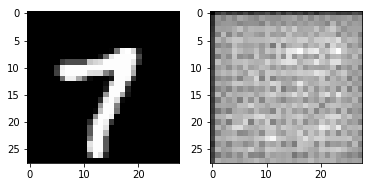

In [5]:
plt.subplot(1, 2, 1)
plt.imshow(x[0].reshape([28, 28]), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(out[0], axis=-1), cmap='gray');